In [15]:
import torch
import torch.nn as nn
import numpy as np
import h5py as h5
import os
import copy
import matplotlib.pyplot as plt

import src.datamaker as datamaker
import src.training as training
import src.models as models

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from importlib import reload
reload(datamaker)
reload(training)
reload(models)

<module 'src.models' from '/home/b7009348/CosyMAML/src/models.py'>

In [16]:
class HDF5Dataset(Dataset):
    def __init__(self, file_path):
        self.file = file_path
        with h5.File(file_path, 'r') as f:
            self.len = f['X_train'].shape[0] # number of tasks
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        with h5.File(self.file, 'r') as f:
            X = f['X_train'][idx]
            y = f['y_train'][idx]
        return X, y
    
dataset = HDF5Dataset('data/1000tasks_5000samples_14seed.h5')
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

for batch in dataloader:
    X, y = batch
    print(X.shape, y.shape)
    break

torch.Size([16, 5000, 10]) torch.Size([16, 5000, 750])


In [17]:
class NPZDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        # Load metadata only to get the shape of the dataset
        with np.load(file_path, mmap_mode='r') as data:
            self.data_len = data['X_train'].shape[0]

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        # Load the file and access only the needed data
        with np.load(self.file_path, mmap_mode='r') as data:
            x = data['X_train'][idx]
            y = data['y_train'][idx]
        return x, y

# Instantiate the dataset and DataLoader
filename = 'data/1000tasks_5000samples_14seed.npz'
dataset = NPZDataset(filename)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

x_batch, y_batch = next(iter(dataloader))

KeyboardInterrupt: 

In [8]:
# load in the data
filename = 'data/200tasks_2000samples.npz'

if os.path.isfile(filename):
    with np.load(filename, allow_pickle=True) as data:
        X_train = data['X_train']
        y_train = data['y_train']

np.random.seed(14)

# Isolate 5 tasks for testing
all_inds = np.arange(X_train.shape[0])
n_test = 5
test_inds = np.random.choice(X_train.shape[0], n_test, replace=False)
train_inds = np.delete(all_inds, test_inds)

X_test = X_train[test_inds]
y_test = y_train[test_inds]
X_train = X_train[train_inds]
y_train = y_train[train_inds]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
# split the data into support and query sets
# shape (n_tasks, n_samples, n_features)
spt_frac = 0.8
x_spt, y_spt, x_qry, y_qry = support_query_split(X_train, y_train, spt_frac)

# convert to torch tensors
x_spt = torch.tensor(x_spt, dtype=torch.float32)
y_spt = torch.tensor(y_spt, dtype=torch.float32)
x_qry = torch.tensor(x_qry, dtype=torch.float32)
y_qry = torch.tensor(y_qry, dtype=torch.float32)
print(x_spt.size(), y_spt.size(), x_qry.size(), y_qry.size())

# take log of the target data and scale
y_spt = torch.log(y_spt)
y_qry = torch.log(y_qry)

(195, 2000, 10) (195, 2000, 750) (5, 2000, 10) (5, 2000, 750)
torch.Size([195, 1600, 10]) torch.Size([195, 1600, 750]) torch.Size([195, 400, 10]) torch.Size([195, 400, 750])


In [17]:
class MetaLearner():
    '''
    Simplified class implementing a meta-learning algorithm.
    '''
    def __init__(
            self,
            model,
            loss_fn=nn.MSELoss(),
            inner_lr=0.001,
            outer_lr=0.01,
            inner_decay=0,
            outer_decay=0,
            seed=None,
            device=None
            ):
        
        # Meta learning variables
        self.model = model
        self.loss_fn = loss_fn
        self.inner_lr = inner_lr
        self.outer_lr = outer_lr
        self.inner_decay = inner_decay
        self.outer_decay = outer_decay

        # Set seed for reproducibility
        if seed is not None:
            torch.manual_seed(seed)
        self.rng = np.random.RandomState(seed)
        
        # Set device for torch tensors
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
        self.model.to(self.device)

        # Initialize Adam parameters
        self.adam_params = {}
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.adam_params[name] = {
                    'm': torch.zeros_like(param),
                    'v': torch.zeros_like(param),
                    't': 0
                }

        self.beta1=0.9
        self.beta2=0.999
        self.epsilon=1e-8

        # Detect anomalies in the computational graph
        torch.autograd.set_detect_anomaly(True)

    def _update_adam_params(self, adam_params, step):
            for name, param in self.model.named_parameters():
                if param.requires_grad:
                    adam_state = adam_params[name]
                    grad = param.grad.data
                    # Update biased first moment estimate
                    adam_state['m'] = self.beta1 * adam_state['m'] + (1 - self.beta1) * grad
                    # Update biased second raw moment estimate
                    adam_state['v'] = self.beta2 * adam_state['v'] + (1 - self.beta2) * (grad ** 2)
                    adam_state['t'] += 1

                    # Compute bias-corrected first moment estimate
                    m_hat = adam_state['m'] / (1 - self.beta1 ** adam_state['t'])
                    # Compute bias-corrected second raw moment estimate
                    v_hat = adam_state['v'] / (1 - self.beta2 ** adam_state['t'])

                    # Update parameters
                    param.data -= step * m_hat / (torch.sqrt(v_hat) + self.epsilon)

    def inner_update(self, x, y, adam_params, steps=1):
        '''
        Perform an inner update on the model.
        '''
        # Check if model has dropout and if so, enable
        if hasattr(self.model, 'dropout'):
            self.model.train()

        # zero gradients before training
        for _ in range(steps):
            self.model.zero_grad()
            y_pred = self.model(x)
            loss = self.loss_fn(y_pred, y)
            loss.backward()

            # Update model parameters with Adam
            self._update_adam_params(adam_params, self.inner_lr)
            
    def meta_train(self, outer_epochs, inner_steps, x_spt, y_spt, x_qry, y_qry):

        # determine number of tasks
        n_tasks = x_spt.shape[0]
        tasks = np.arange(n_tasks)
        tasks = self.rng.permutation(tasks)
        if n_tasks < (outer_epochs * n_tasks):
            tasks = np.tile(tasks, int(np.ceil(outer_epochs*n_tasks/n_tasks)))

        meta_losses = []
        for i, task in enumerate(tasks):

            # copy model weights
            meta_weights = copy.deepcopy(self.model.state_dict())

            # sample a task
            x_spt_task = x_spt[task].to(self.device)
            y_spt_task = y_spt[task].to(self.device)
            x_qry_task = x_qry[task].to(self.device)
            y_qry_task = y_qry[task].to(self.device)

            # Apply scaling
            scaler_x = training.TorchStandardScaler()
            x_spt_task = scaler_x.fit_transform(x_spt_task)
            x_qry_task = scaler_x.transform(x_qry_task)

            scaler_y = training.TorchStandardScaler()
            y_spt_task = scaler_y.fit_transform(y_spt_task)
            y_qry_task = scaler_y.transform(y_qry_task)

            # inner update
            self.inner_update(
                x_spt_task,
                y_spt_task,
                self.adam_params,
                steps=inner_steps
            )

            # Check if model has dropout layers and if so enable dropout
            if hasattr(self.model, 'dropout'):
                self.model.train()

            self.model.zero_grad()
            y_pred = self.model(x_qry_task)
            loss = self.loss_fn(y_pred, y_qry_task)
            loss.backward()
            meta_losses.append(loss.item())

            # Reload meta weights
            self.model.load_state_dict(meta_weights)

            # Update model parameters with Adam
            self._update_adam_params(self.adam_params, self.outer_lr)
        
            print(f'Epoch {i+1}/{(outer_epochs*n_tasks)} - Loss: {loss.item()}')

        return meta_losses
    
    def adapt_and_predict(self, x_spt, y_spt, x_qry, steps, n_pred=100):

        # Send data to device
        x_spt = x_spt.to(self.device)
        y_spt = y_spt.to(self.device)
        x_qry = x_qry.to(self.device)

        # Apply scaling
        scaler_x = training.TorchStandardScaler()
        x_spt = scaler_x.fit_transform(x_spt)
        x_qry = scaler_x.transform(x_qry)

        scaler_y = training.TorchStandardScaler()
        y_spt = scaler_y.fit_transform(y_spt)

        # Copy model weights
        meta_weights = copy.deepcopy(self.model.state_dict())

        finetune_adam_params = {}
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                finetune_adam_params[name] = {
                    'm': torch.zeros_like(param),
                    'v': torch.zeros_like(param),
                    't': 0
                }

        # Inner update
        self.inner_update(
            x_spt,
            y_spt,
            finetune_adam_params,
            steps=steps
        )

        # Predict on query set
        
        if hasattr(self.model, 'dropout') and n_pred is not None:
            self.model.train()
            y_pred_list = []
            for _ in range(n_pred):
                y_pred = self.model(x_qry)
                y_pred = scaler_y.inverse_transform(y_pred)
                y_pred = y_pred.cpu().detach().numpy()
                y_pred = y_pred_list.append(y_pred)
            y_pred = np.stack(y_pred_list, axis=0)
            y_pred = np.mean(y_pred, axis=0)
        else:
            y_pred = self.model(x_qry)
            y_pred = scaler_y.inverse_transform(y_pred)
            y_pred = y_pred.cpu().detach().numpy()

        # Reload meta weights
        self.model.load_state_dict(meta_weights)

        return y_pred

Epoch 1/195 - Loss: 0.2815808653831482
Epoch 2/195 - Loss: 0.9348989725112915
Epoch 3/195 - Loss: 0.8961068987846375
Epoch 4/195 - Loss: 0.6657784581184387
Epoch 5/195 - Loss: 0.14594405889511108
Epoch 6/195 - Loss: 0.20178310573101044
Epoch 7/195 - Loss: 0.60637366771698
Epoch 8/195 - Loss: 0.28350067138671875
Epoch 9/195 - Loss: 0.1049819141626358
Epoch 10/195 - Loss: 0.17095184326171875
Epoch 11/195 - Loss: 0.07329726219177246
Epoch 12/195 - Loss: 0.08319655060768127
Epoch 13/195 - Loss: 0.06330852955579758
Epoch 14/195 - Loss: 0.0801139548420906
Epoch 15/195 - Loss: 0.09315429627895355
Epoch 16/195 - Loss: 0.053940702229738235
Epoch 17/195 - Loss: 0.10131261497735977
Epoch 18/195 - Loss: 0.05008203536272049
Epoch 19/195 - Loss: 0.08567613363265991
Epoch 20/195 - Loss: 0.07427284121513367
Epoch 21/195 - Loss: 0.11097003519535065
Epoch 22/195 - Loss: 0.10168279707431793
Epoch 23/195 - Loss: 0.1144285798072815
Epoch 24/195 - Loss: 0.09614837914705276
Epoch 25/195 - Loss: 0.03813308104

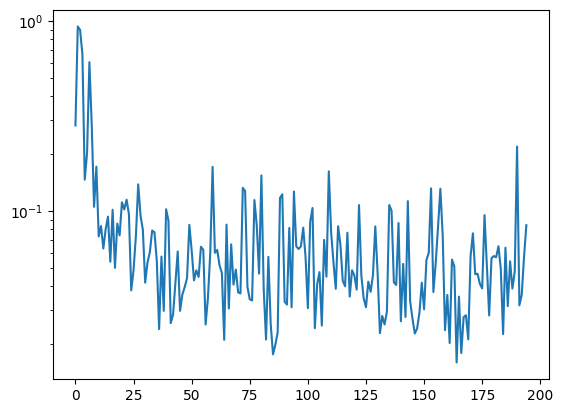

In [18]:
model = models.ModableCNN(
    input_size=x_spt.size(-1),
    latent_dim=(16,16),
    output_dim=y_spt.size(-1),
    dropout_rate=0.2
)

meta_learner = MetaLearner(
    model=model,
    loss_fn=nn.MSELoss(),
    inner_lr=0.001,
    outer_lr=0.01,
    seed=14
)

meta_losses = meta_learner.meta_train(
    outer_epochs=1,
    inner_steps=10,
    x_spt=x_spt,
    y_spt=y_spt,
    x_qry=x_qry,
    y_qry=y_qry
)

plt.plot(meta_losses)
plt.yscale('log')

Support samples: 600
Minimum MAPE: 0.6237607175587596, Maximum MAPE: 69.45400959379687
Task 1 - Failure rate: 0.21
Minimum MAPE: 0.7052201347767206, Maximum MAPE: 42.58665722826641
Task 2 - Failure rate: 0.2664285714285714
Minimum MAPE: 0.46194295151826836, Maximum MAPE: 27.41348944456107
Task 3 - Failure rate: 0.1657142857142857
Minimum MAPE: 0.5306681604878594, Maximum MAPE: 49.18466847568967
Task 4 - Failure rate: 0.17285714285714285
Minimum MAPE: 0.43415347522036374, Maximum MAPE: 46.71593340321914
Task 5 - Failure rate: 0.22357142857142856


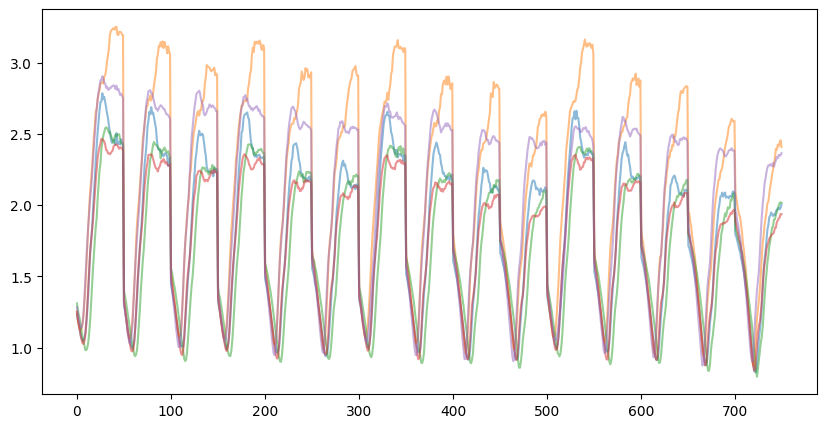

In [6]:
# Test the model
# split the data into support and query sets
spt_frac = 0.3
x_spt_test, y_spt_test, x_qry_test, y_qry_test = support_query_split(X_test, y_test, spt_frac)
# convert to torch tensors
x_spt_test = torch.tensor(x_spt_test, dtype=torch.float32)
y_spt_test = torch.tensor(y_spt_test, dtype=torch.float32)
x_qry_test = torch.tensor(x_qry_test, dtype=torch.float32)
print('Support samples:', x_spt_test.size(1))

# take log of y_spt_test
y_spt_test = torch.log(y_spt_test)

# fine-tune the model on the test tasks
fig, ax = plt.subplots(1,1, figsize=(10,5))
for i in range(x_spt_test.size(0)):
    y_pred = meta_learner.adapt_and_predict(
        x_spt_test[i],
        y_spt_test[i],
        x_qry_test[i],
        steps=512
    )
    y_pred = np.exp(y_pred)
    y_true = y_qry_test[i]

    ape = abs((y_pred - y_true) / y_true * 100)
    ell_mape = np.max(ape, axis=1)
    failure_rate = len(ell_mape[ell_mape>5]) / len(ape)
    print(f'Minimum MAPE: {np.min(ell_mape)}, Maximum MAPE: {np.max(ell_mape)}')
    print(f'Task {i+1} - Failure rate: {failure_rate}')
    sample_mape = np.mean(ape, axis=0)
    ax.plot(sample_mape, label=f'Task {i+1}', alpha=0.5)

In [13]:
class CosMOE():
    def __init__(self, model, outer_lr=0.01, inner_lr=0.001, loss_fn=nn.MSELoss, 
                 beta1=0.9, beta2=0.999, epsilon=1e-8, seed=None, device=None):
        self.model = model
        self.outer_lr = outer_lr
        self.inner_lr = inner_lr
        self.loss_fn = loss_fn()
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.rng = np.random.RandomState(seed)

        torch.manual_seed(seed)

        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
        self.model.to(self.device)

        # Initialize Adam parameters
        self.adam_params = {}
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.adam_params[name] = {
                    'm': torch.zeros_like(param).to(self.device),
                    'v': torch.zeros_like(param).to(self.device),
                    't': 0
                }

    def inner_update(self, x, y, fast_weights, steps):
        '''
        Perform an inner update on the model.
        
        Args:
        - x: the input data.
        - y: the target data.
        - fast_weights: the model parameters as a dictionary.
        - steps: the number of steps to update the model.
        '''

        if hasattr(self.model, 'dropout'):
            self.model.train()

        for _ in range(steps):
            self.model.zero_grad()
            y_pred = self.model(x, params=fast_weights)
            loss = self.loss_fn(y_pred, y)
            grad = torch.autograd.grad(loss, fast_weights.values())

            # Update with Adam
            for (name, param), g in zip(fast_weights.items(), grad):
                adam_state = self.adam_params[name]
                adam_state['t'] += 1
                adam_state['m'] = self.beta1 * adam_state['m'] + (1 - self.beta1) * g
                adam_state['v'] = self.beta2 * adam_state['v'] + (1 - self.beta2) * g**2
                m_hat = adam_state['m'] / (1 - self.beta1**adam_state['t'])
                v_hat = adam_state['v'] / (1 - self.beta2**adam_state['t'])
                fast_weights[name] = param - self.inner_lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)

        return fast_weights

    def meta_train(self, x_spt, y_spt, x_qry, y_qry, batch_size=10, inner_steps=10, outer_epochs=100):
        meta_losses = []
        m = []
        v = []
        for i in range(outer_epochs):
            task_batch = self.rng.choice(x_spt.size(0), batch_size, replace=True)
            meta_loss = 0
            for _, task in enumerate(task_batch):
                x_spt_task = x_spt[task].to(self.device)
                y_spt_task = y_spt[task].to(self.device)
                x_qry_task = x_qry[task].to(self.device)
                y_qry_task = y_qry[task].to(self.device)

                # Scale data
                scaler_x = training.TorchStandardScaler()
                x_spt_task = scaler_x.fit_transform(x_spt_task)
                x_qry_task = scaler_x.transform(x_qry_task)

                scaler_y = training.TorchStandardScaler()
                y_spt_task = scaler_y.fit_transform(y_spt_task)
                y_qry_task = scaler_y.transform(y_qry_task)

                # Initialize fast weights
                fast_weights = {name: param.clone().requires_grad_(True) 
                                for name, param in self.model.named_parameters()}

                # Inner update
                fast_weights = self.inner_update(
                                x_spt_task,
                                y_spt_task,
                                fast_weights,
                                steps=inner_steps
                            )
                
                m.append(self.adam_params['conv1.weight']['m'].cpu().detach().numpy())
                v.append(self.adam_params['conv1.weight']['v'].cpu().detach().numpy())

                if hasattr(self.model, 'dropout'):
                    self.model.train()

                # Zero gradients
                self.model.zero_grad()
                y_pred = self.model(x_qry_task, params=fast_weights)
                loss_qry = self.loss_fn(y_pred, y_qry_task)

                # Accumulate losses
                meta_loss += loss_qry

            # Normalise meta loss
            meta_loss /= batch_size

            # Update model parameters with Adam
            grad = torch.autograd.grad(meta_loss, self.model.parameters())
            # Update with Adam
            for (name, param), g in zip(self.model.named_parameters(), grad):
                adam_state = self.adam_params[name]
                adam_state['t'] += 1
                adam_state['m'] = self.beta1 * adam_state['m'] + (1 - self.beta1) * g
                adam_state['v'] = self.beta2 * adam_state['v'] + (1 - self.beta2) * g**2
                m_hat = adam_state['m'] / (1 - self.beta1**adam_state['t'])
                v_hat = adam_state['v'] / (1 - self.beta2**adam_state['t'])
                param.data -= self.outer_lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)

            meta_losses.append(meta_loss.detach().item())
            m.append(self.adam_params['conv1.weight']['m'].cpu().detach().numpy())
            v.append(self.adam_params['conv1.weight']['v'].cpu().detach().numpy())
            print(f'Epoch {i+1}/{outer_epochs} - Loss: {meta_loss.item()}')

        return meta_losses, m, v
    
    def adapt_and_predict(self, x_spt, y_spt, x_qry, steps, n_pred=100):

        # Send data to device
        x_spt = x_spt.to(self.device)
        y_spt = y_spt.to(self.device)
        x_qry = x_qry.to(self.device)

        # Apply scaling
        scaler_x = training.TorchStandardScaler()
        x_spt = scaler_x.fit_transform(x_spt)
        x_qry = scaler_x.transform(x_qry)

        scaler_y = training.TorchStandardScaler()
        y_spt = scaler_y.fit_transform(y_spt)

        # Copy model weights
        fast_weights = {name: param.clone().requires_grad_(True) 
                        for name, param in self.model.named_parameters()}

        # Inner update with new optimiser state
        adapt_adam = {}
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                adapt_adam[name] = {
                    'm': torch.zeros_like(param).to(self.device),
                    'v': torch.zeros_like(param).to(self.device),
                    't': 0
                }

        for _ in range(steps):
            self.model.zero_grad()
            y_pred = self.model(x, params=fast_weights)
            loss = self.loss_fn(y_pred, y)
            grad = torch.autograd.grad(loss, fast_weights.values())

            # Update with Adam
            for (name, param), g in zip(fast_weights.items(), grad):
                adam_state = adapt_adam[name]
                adam_state['t'] += 1
                adam_state['m'] = self.beta1 * adam_state['m'] + (1 - self.beta1) * g
                adam_state['v'] = self.beta2 * adam_state['v'] + (1 - self.beta2) * g**2
                m_hat = adam_state['m'] / (1 - self.beta1**adam_state['t'])
                v_hat = adam_state['v'] / (1 - self.beta2**adam_state['t'])
                fast_weights[name] = param - self.inner_lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)

        # Predict on query set
        if hasattr(self.model, 'dropout') and n_pred is not None:
            self.model.train()
            y_pred_list = []
            for _ in range(n_pred):
                y_pred = self.model(x_qry, params=fast_weights)
                y_pred = scaler_y.inverse_transform(y_pred)
                y_pred = y_pred.cpu().detach().numpy()
                y_pred = y_pred_list.append(y_pred)
            y_pred = np.stack(y_pred_list, axis=0)
            y_pred = np.mean(y_pred, axis=0)
        else:
            y_pred = self.model(x_qry, params=fast_weights)
            y_pred = scaler_y.inverse_transform(y_pred)
            y_pred = y_pred.cpu().detach().numpy()

        return y_pred

<class 'dict'>
Epoch 1/1 - Loss: 0.5371119976043701


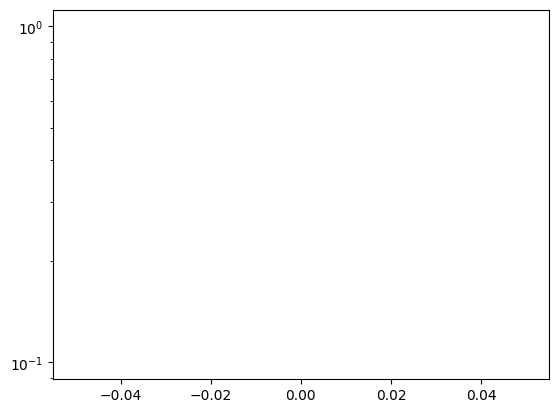

In [14]:
model = models.ModableCNN(
    input_size=x_spt.size(-1),
    latent_dim=(16,16),
    output_dim=y_spt.size(-1),
    dropout_rate=0.2
)

meta_learner = CosMOE(
    model=model,
    outer_lr=0.01,
    inner_lr=0.001,
    seed=14
)

meta_losses, m, v = meta_learner.meta_train(
    x_spt=x_spt,
    y_spt=y_spt,
    x_qry=x_qry,
    y_qry=y_qry,
    batch_size=20,
    inner_steps=5,
    outer_epochs=400
)

plt.plot(meta_losses)
plt.yscale('log')

Support samples: 400
Minimum MAPE: 0.5535593623740404, Maximum MAPE: 50.511827169380574
Task 1 - Failure rate: 0.101875
Minimum MAPE: 0.6111266897908976, Maximum MAPE: 28.107545598976618
Task 2 - Failure rate: 0.13625
Minimum MAPE: 0.5550673159146332, Maximum MAPE: 21.533011641666448
Task 3 - Failure rate: 0.08875
Minimum MAPE: 0.6447495141279187, Maximum MAPE: 26.809793833377483
Task 4 - Failure rate: 0.1
Minimum MAPE: 0.7865700952577435, Maximum MAPE: 25.57974673347466
Task 5 - Failure rate: 0.198125


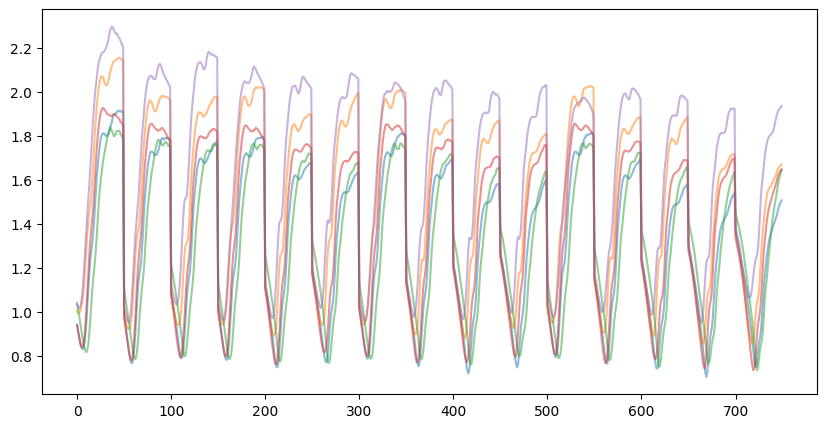

In [38]:
# Test the model
# split the data into support and query sets
spt_frac = 0.2
x_spt_test, y_spt_test, x_qry_test, y_qry_test = support_query_split(X_test, y_test, spt_frac)
# convert to torch tensors
x_spt_test = torch.tensor(x_spt_test, dtype=torch.float32)
y_spt_test = torch.tensor(y_spt_test, dtype=torch.float32)
x_qry_test = torch.tensor(x_qry_test, dtype=torch.float32)
print('Support samples:', x_spt_test.size(1))

# take log of y_spt_test
y_spt_test = torch.log(y_spt_test)

# fine-tune the model on the test tasks
fig, ax = plt.subplots(1,1, figsize=(10,5))
for i in range(x_spt_test.size(0)):
    y_pred = meta_learner.adapt_and_predict(
        x_spt_test[i],
        y_spt_test[i],
        x_qry_test[i],
        steps=128
    )
    y_pred = np.exp(y_pred)
    y_true = y_qry_test[i]

    ape = abs((y_pred - y_true) / y_true * 100)
    ell_mape = np.max(ape, axis=1)
    failure_rate = len(ell_mape[ell_mape>5]) / len(ape)
    print(f'Minimum MAPE: {np.min(ell_mape)}, Maximum MAPE: {np.max(ell_mape)}')
    print(f'Task {i+1} - Failure rate: {failure_rate}')
    sample_mape = np.mean(ape, axis=0)
    ax.plot(sample_mape, label=f'Task {i+1}', alpha=0.5)